<a href="https://colab.research.google.com/github/NDDV/Text-Classification-and-Image-caption-with-CNN/blob/main/text-image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#text classification


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
train = "/content/drive/MyDrive/train.csv" 

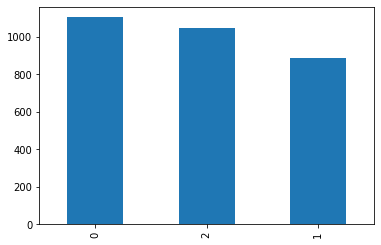

In [ ]:
names =['Classes','Content']
df = pd.read_csv(train, names=names)
df['Classes'].value_counts().plot.bar()

In [ ]:
df

,Classes,Content
0,0,máy dùng hay bị đơ máy
1,0,chỉ có dây cáp nguồn không có adapter sao sử d...
2,0,Chất lượng quá kém Mới dùng được 2 ngày loa ba...
3,0,Usb tôi vừa mới nhận usb này Rất bực bội vì cá...
4,2,Tuyệt vời. Hàng FPT cửa hàng
...,...,...
3035,0,không có bộ thu đi kèm Vừa nhận hàng xong tức ...
3036,0,Cũng bình thường Không mạnh như kỹ vọng Chắc t...
3037,2,tốt tốt đang tiền khi bỏ ra để mua giao hàng n...
3038,0,giao hàng lâu rửa tay một tí đã cháy màn hình ...


In [ ]:
alphabet = 'aAàÀảẢãÃáÁạẠăĂằẰẳẲẵẴắẮặẶâÂầẦẩẨẫẪấẤậẬbBcCdDđĐeEèÈẻẺẽẼéÉẹẸêÊềỀểỂễỄếẾệỆfFgGhHiIìÌỉỈĩĨíÍịỊjJkKlLmMnNoOòÒỏỎõÕóÓọỌôÔồỒổỔỗỖốỐộỘơƠờỜởỞỡỠớỚợỢpPqQrRsStTuUùÙủỦũŨúÚụỤưƯừỪửỬữỮứỨựỰvVwWxXyYỳỲỷỶỹỸýÝỵỴzZ0123456789 '

In [ ]:
!pip install underthesea

In [ ]:
import string
def cleantext(text):
  text=text.translate(string.punctuation)
  text = text.lower().split()
  text = " ".join(text)
  return text

In [ ]:
df['Content'] = df['Content'].map(lambda x: cleantext(x))

In [ ]:
!wget https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords.txt

--2022-04-12 10:05:56--  https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20475 (20K) [text/plain]
Saving to: ‘vietnamese-stopwords.txt’

vietnamese-stopword 100%[===================>]  20.00K  --.-KB/s    in 0.001s  

2022-04-12 10:05:56 (14.8 MB/s) - ‘vietnamese-stopwords.txt’ saved [20475/20475]



In [ ]:
filename = '/content/drive/MyDrive/vietnamese-stopwords.txt'
data = pd.read_csv(filename,names=['stopwords'], sep="\t", encoding='utf-8')
list_stopwords = data['stopwords']
def remove_stopword(text):
    pre_text = []
    words = text.split()
    for word in words:
        if word not in list_stopwords:
            pre_text.append(word)
        text2 = ' '.join(pre_text)
    return text2

In [ ]:
df['Content'] = df['Content'].map(lambda x: remove_stopword(x))

In [ ]:
from underthesea import word_tokenize
# create dictionary text
word_count_threshold = 3
word_counts = {}
nsents = 0
for sent in df['Content']:
    nsents += 1
    for w in word_tokenize(sent,format='text').split():
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print(len(word_counts), len(vocab))

4235 1819


In [ ]:
id2word = {}
word2id = {}
ix = 1
for w in vocab:
    word2id[w] = ix
    id2word[ix] = w
    ix += 1
vocab_size = len(word2id) + 1  # Thêm 1 cho từ dùng để padding

In [ ]:
def maxlen(descriptions):
  all_des = list()
  for i in descriptions:
    word = i.split(" ")
    all_des.append(len(word))
  return max(all_des)

max_length_text = maxlen(df['Content'])
print("Số từ trong câu dài nhất: ", (max_length_text))
print(id2word[5])
print(len(id2word))

Số từ trong câu dài nhất:  366
đơ
1819


In [ ]:
from gensim.models import Word2Vec
import os
import pandas as pd
path = '/content/drive/MyDrive/train.csv'

def readdata(path):
    names =['Classes','Content']
    df = pd.read_csv(path, names=names)
      
    return df.Content, df.Classes

readdata(path)

In [ ]:
Content, Classes = readdata(path)
input_gensim = []
for Cont in Content:
    input_gensim.append(Cont.split())
    
model = Word2Vec(input_gensim, size=128, window=5, min_count=0, workers=4, sg=1)
model.wv.save("word.model")

In [ ]:
import gensim.models.keyedvectors as word2vec
model_embedding = word2vec.KeyedVectors.load('/content/drive/MyDrive/word.model')

word_labels = []
max_seq = max_length_text
embedding_size = 128

for word in model_embedding.vocab.keys():
    word_labels.append(word)

def comment_embedding(comment):
    matrix = np.zeros((max_seq, embedding_size))
    words = comment.split()
    lencmt = len(words)

    for i in range(max_seq):
        indexword = i % lencmt
        if (max_seq - i < lencmt):
            break
        if(words[indexword] in word_labels):
            matrix[i] = model_embedding[words[indexword]]
    matrix = np.array(matrix)
    return matrix

In [ ]:
from tqdm import tqdm
train_data = []
label_data = []

for x in tqdm(Content):
    matrix = np.zeros((max_seq, embedding_size))
    words = x.split()
    lencmt = len(words)
    for i in range(max_seq):
        indexword = i % lencmt
        if (max_seq - i < lencmt):
            break
        if(words[indexword] in word_labels):
            matrix[i] = model_embedding[words[indexword]]
    matrix = np.array(matrix)
    train_data.append(matrix)
train_data = np.array(train_data)

for y in tqdm(Classes):
    label_ = np.zeros(3)
    try:
        label_[int(y)] = 1
    except:
        label_[0] = 1
    label_data.append(label_)

100%|██████████| 3040/3040 [00:00<00:00, 322206.66it/s]


In [ ]:
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf
from keras.preprocessing import sequence

sequence_length = max_length_text
embedding_size = 128
num_classes = 3
filter_sizes = 3
num_filters = 150
epochs = 50
batch_size = 30
learning_rate = 0.01
dropout_rate = 0.5

In [ ]:
x_train = train_data.reshape(train_data.shape[0], sequence_length, embedding_size, 1).astype('float32')
y_train = np.array(label_data)

# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(num_filters, (filter_sizes, embedding_size),
                        padding='valid',
                        input_shape=(sequence_length, embedding_size, 1), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(198, 1)))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
# Train model
adam = tf.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 364, 1, 150)       57750     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 150)        0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 1, 1, 150)         0         
                                                                 
 flatten_2 (Flatten)         (None, 150)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               19328     
                                                                 
 dense_5 (Dense)             (None, 3)                 387       
                                                      

In [ ]:
history = model.fit(x = x_train[:2500], y = y_train[:2500], batch_size = batch_size, verbose=1, epochs=5, validation_data=(x_train[:540], y_train[:540]))

model.save('models_5.h5')

Epoch 1/5
84/84 [==============================] - 9s 101ms/step - loss: 0.2850 - accuracy: 0.8916 - val_loss: 0.1229 - val_accuracy: 0.9722
Epoch 2/5
84/84 [==============================] - 8s 90ms/step - loss: 0.2696 - accuracy: 0.8864 - val_loss: 0.1161 - val_accuracy: 0.9796
Epoch 3/5
84/84 [==============================] - 8s 91ms/step - loss: 0.2742 - accuracy: 0.8928 - val_loss: 0.1204 - val_accuracy: 0.9778
Epoch 4/5
84/84 [==============================] - 8s 90ms/step - loss: 0.2723 - accuracy: 0.8908 - val_loss: 0.1103 - val_accuracy: 0.9870
Epoch 5/5
84/84 [==============================] - 8s 90ms/step - loss: 0.2735 - accuracy: 0.8928 - val_loss: 0.1348 - val_accuracy: 0.9704


In [ ]:
from keras.models import load_model
model_sentiment = load_model("models_5.h5")

In [ ]:
def pre_process(text):
  text=text.translate(string.punctuation)
  text = text.lower().split()
  text = " ".join(text)
  return text

text = "đồ ăn ở đây vừa nhiều vừa ngon"
text = pre_process(text)

maxtrix_embedding = np.expand_dims(comment_embedding(text), axis=0)
maxtrix_embedding = np.expand_dims(maxtrix_embedding, axis=3)

result = model.predict(maxtrix_embedding)
result = np.argmax(result)
print("Label predict: ", result)

Label predict:  2


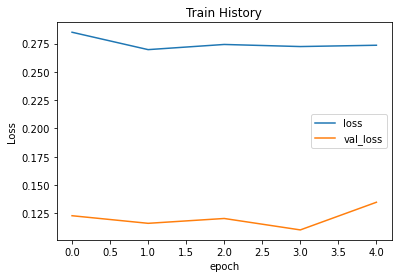

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train History')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['loss','val_loss'])
plt.show()

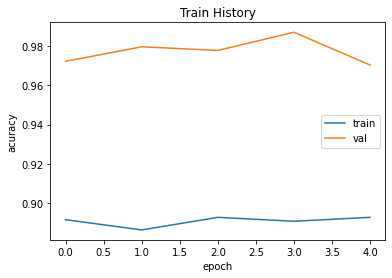

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Train History')
plt.xlabel('epoch')
plt.ylabel('acuracy')
plt.legend(['train','val'])
plt.show()

#XLA comment


In [ ]:
!pip -q install pyvi
from pyvi import ViTokenizer

     |████████████████████████████████| 8.5 MB 6.7 MB/s 
     |████████████████████████████████| 965 kB 24.9 MB/s 


In [ ]:
import progressbar
import string
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, InputLayer \
, Dense, Embedding, LSTM, Dropout, Concatenate, RepeatVector, TimeDistributed, Activation
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import sys
import time
import os
import warnings 
import numpy as np
from numpy import array
import pandas as pd 
import glob 
import pickle
warnings.filterwarnings("ignore")

In [ ]:
dir_Flickr_text = "/content/drive/MyDrive/NLP_XLA_data/Flickr8k.token_VN.txt"
dir_Flickr_jpg_train = "/content/drive/MyDrive/NLP_XLA_data/Flickr_8k.trainImages.txt"
dir_Flickr_jpg_test = "/content/drive/MyDrive/NLP_XLA_data/Flickr_8k.testImages.txt"

In [ ]:
# Đọc file các caption
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
doc = load_doc(dir_Flickr_text)
print(doc[:500])

1000268201_693b08cb0e.jpg # 0 Một đứa trẻ mặc váy hồng đang trèo lên một bộ cầu thang theo lối vào.
1000268201_693b08cb0e.jpg # 1 Một cô gái đi vào một tòa nhà bằng gỗ.
1000268201_693b08cb0e.jpg # 2 Một cô bé trèo vào nhà chơi bằng gỗ.
1000268201_693b08cb0e.jpg # 3 Một cô bé leo lên cầu thang đến nhà chơi của mình.
1000268201_693b08cb0e.jpg # 4 Một cô bé mặc váy hồng đi vào cabin gỗ.
1001773457_577c3a7d70.jpg # 0 Một con chó đen và một con chó đốm đang chiến đấu
1001773457_577c3a7d70.jpg # 1 Một


In [ ]:
# Lưu caption dưới dạng key value: id_image : ['caption 1', 'caption 2', 'caption 3',' caption 4', 'caption 5']
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[3:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8112 


In [ ]:
# Preprocessing Vietnamese text
import re
exclude = list(string.punctuation) + list(string.digits)
exclude.pop(exclude.index('_'))
def clean_descriptions_vi(descriptions):
  # prepare translation table for removing punctuation
  for key, desc_list in descriptions.items():
      for i in range(len(desc_list)):
        sent = desc_list[i]
        sent = sent.lower()
        sent = sent.strip()
        sent = re.sub("'", " ", sent)
        sent = re.sub("\s+", " ", sent)
        sent = ''.join([char for char in sent if char not in exclude])
        sent = ViTokenizer.tokenize(sent)
        sent = 'startseq ' + sent + ' endseq'
        desc_list[i] = sent
  return descriptions
# clean descriptions
clean_descriptions_vi(descriptions)

{'1000268201_693b08cb0e': ['startseq một đứa trẻ mặc váy hồng đang trèo lên một bộ cầu_thang theo lối vào endseq',
  'startseq một cô gái đi vào một tòa nhà bằng gỗ endseq',
  'startseq một cô bé trèo vào nhà chơi bằng gỗ endseq',
  'startseq một cô bé leo lên cầu_thang đến nhà chơi của mình endseq',
  'startseq một cô bé mặc váy hồng đi vào cabin gỗ endseq'],
 '1001773457_577c3a7d70': ['startseq một con chó đen và một con chó đốm đang chiến_đấu endseq',
  'startseq một con chó đen và một con chó ba màu đang chơi với nhau trên đường endseq',
  'startseq một con chó đen và một con chó trắng có đốm_nâu đang nhìn chằm_chằm vào nhau trên đường_phố endseq',
  'startseq hai con chó thuộc các giống khác nhau nhìn nhau trên đường endseq',
  'startseq hai con chó trên vỉa_hè di_chuyển về phía nhau endseq'],
 '1002674143_1b742ab4b8': ['startseq một cô bé được phủ sơn ngồi trước cầu_vồng được vẽ bằng tay trong một cái bát endseq',
  'startseq một cô bé đang ngồi trước cầu_vồng lớn được sơn endseq

['startseq một người leo núi đang tạo dáng trước những ngọn núi tuyết endseq',
 'startseq một người leo núi đang đứng trước ngọn núi cầm hai cây gậy đi bộ endseq',
 'startseq một người đàn_ông đứng trước những ngọn núi phủ tuyết endseq',
 'startseq một người đàn_ông có hai cột trượt_tuyết đứng gần đỉnh núi endseq',
 'startseq người đàn_ông đội mũ và áo_khoác màu xanh lá cây khi đứng trước một ngọn núi endseq']

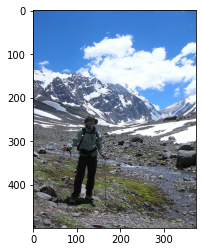

In [ ]:
import matplotlib.pyplot as plt
id = '2098174172_e57d86ea03'
img = plt.imread('/content/drive/MyDrive/NLP_XLA_data/Flicker8k_Dataset/'+id+'.jpg')
plt.imshow(img, cmap='brg')
descriptions[id]

In [ ]:
# Lưu description xuống file
# def save_descriptions(descriptions, filename):
# 	lines = list()
# 	for key, desc_list in descriptions.items():
# 		for desc in desc_list:
# 			lines.append(key + ' ' + desc)
# 	data = '\n'.join(lines)
# 	file = open(filename, 'w')
# 	file.write(data)
# 	file.close()

# save_descriptions(descriptions, '/content/drive/MyDrive/NLP_XLA_data/descriptions.txt')

In [ ]:
# Lấy id ảnh tương ứng với dữ liệu train, test, dev
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = dir_Flickr_jpg_train
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [ ]:
# Folder chứa dữ ảnh
images = '/content/drive/MyDrive/NLP_XLA_data/Flicker8k_Dataset/'
# Lấy lấy các ảnh jpg trong thư mục
img = glob.glob(images + '*.jpg')

In [ ]:
# File chứa các id ảnh để train
train_images_file = dir_Flickr_jpg_train
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [ ]:
# File chứa các id ảnh để test
test_images_file = dir_Flickr_jpg_test
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [ ]:
# Lấy description ứng với id của tập train
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = ' '.join(image_desc)
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('/content/drive/MyDrive/NLP_XLA_data/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=5886


In [ ]:
def preprocess(image_path):
    # Convert all the images to size image
    img = image.load_img(image_path, target_size=(224, 224))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    return x

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
model = VGG16(include_top=True, weights='imagenet', input_shape=(224, 224, 3))
for layer in model.layers:
  layer.trainable = False
modelVGG16 = Model(model.input, model.layers[-2].output)
modelVGG16.summary()

553476096/553467096 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = modelVGG16.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [ ]:
# save train descriptions
# with open("/content/drive/MyDrive/NLP_XLA_data/train_descriptions.pkl", "wb") as file:
#     pickle.dump(train_descriptions, file)

In [ ]:
# encoding_train = {}
# for img in train_img:
#     encoding_train[img[len(images):]] = encode(img)

In [ ]:
# save encoding train
# with open("/content/drive/MyDrive/NLP_XLA_data/encoded_train_images.pkl", "wb") as encoded_pickle:
#     pickle.dump(encoding_train, encoded_pickle)

In [ ]:
#load encoding train
with open("/content/drive/MyDrive/NLP_XLA_data/encoded_train_images.pkl", "rb") as encoded_pickle:
  encoding_train = pickle.load(encoded_pickle)
encoding_train

In [ ]:
# encoding_test = {}
# for img in test_img:
#    encoding_test[img[len(images):]] = encode(img)

In [ ]:
#save encoding test
# with open("/content/drive/MyDrive/NLP_XLA_data/encoded_test_images.pkl", "wb") as encoded_pickle:
#     pickle.dump(encoding_train, encoded_pickle)

In [ ]:
encoding_train = pickle.load(open("/content/drive/MyDrive/NLP_XLA_data/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(encoding_train))

Photos: train=6000


In [ ]:
encoding_train['3278777548_290b881018.jpg']

array([0.       , 3.5828643, 0.       , ..., 0.       , 0.       ,
       0.       ], dtype=float32)

In [ ]:
# Tạo list các training caption
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

29399

In [ ]:
word_count_threshold = 5
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in ViTokenizer.tokenize(sent).split():
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 4919 -> 2008


In [ ]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1  # Thêm 1 cho từ dùng để padding
vocab_size

2009

In [ ]:
#save wordtoix Và ixtoword
# with open('/content/drive/MyDrive/NLP_XLA_data/wordtoix.pkl','wb') as f:
#   pickle.dump(wordtoix,f)
# with open('/content/drive/MyDrive/NLP_XLA_data/ixtoword.pkl','wb') as f:
#   pickle.dump(ixtoword,f)

In [ ]:
#load wordtoix Và ixtoword
with open("/content/drive/MyDrive/NLP_XLA_data/wordtoix.pkl", "rb") as w2i:
  wordtoix = pickle.load(w2i)
with open("/content/drive/MyDrive/NLP_XLA_data/ixtoword.pkl", "rb") as i2w:
  ixtoword = pickle.load(i2w)

In [ ]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 44


In [ ]:
import gensim.models.keyedvectors as word2vec
!wget https://thiaisotajppub.s3-ap-northeast-1.amazonaws.com/publicfiles/baomoi.window2.vn.model.bin.gz
!gunzip '/content/baomoi.window2.vn.model.bin.gz'
glove_vectors = word2vec.KeyedVectors.load_word2vec_format('/content/baomoi.window2.vn.model.bin',  binary=True, unicode_errors='ignore')

--2022-04-21 03:18:06--  https://thiaisotajppub.s3-ap-northeast-1.amazonaws.com/publicfiles/baomoi.window2.vn.model.bin.gz
Resolving thiaisotajppub.s3-ap-northeast-1.amazonaws.com (thiaisotajppub.s3-ap-northeast-1.amazonaws.com)... 52.219.196.98
Connecting to thiaisotajppub.s3-ap-northeast-1.amazonaws.com (thiaisotajppub.s3-ap-northeast-1.amazonaws.com)|52.219.196.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494402382 (471M) [application/x-gzip]
Saving to: ‘baomoi.window2.vn.model.bin.gz’

baomoi.window2.vn.m 100%[===================>] 471.50M  19.0MB/s    in 26s     

2022-04-21 03:18:33 (18.2 MB/s) - ‘baomoi.window2.vn.model.bin.gz’ saved [494402382/494402382]



In [ ]:
embedding_dim = 300
# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))
embedding_vector = None
for word, i in wordtoix.items():
    #if i < max_words:
    try:
      embedding_vector = glove_vectors[word]
    except:
        pass
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
# data generator cho việc train theo từng batch model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield (array(X1), array(X2)), array(y)
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
# model 
inputs1 = Sequential()
inputs1.add(Dense(embedding_dim, input_shape=(4096,), activation='relu')) # vector đặc trưng của ảnh tùy vào Encode bằng Inceptionv3 hay VGG16 sẽ có input_shape tương ứng
inputs1.add(RepeatVector(max_length)) # nhân số lượng đầu vào bằng với độ dài của câu (để mỗi LSTM sẽ đưa vào mỗi tấm ảnh + với chuỗi để dự đoan từ mới)
# inputs1 cho ra (44,200)
inputs2 = Sequential()
inputs2.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)) # Embedding từ với shape đầu ra là embedding_dim = 200 
inputs2.add(LSTM(embedding_dim, return_sequences=True)) # cho chuỗi đi qua lớp LSTM để tạo ra vector đặc trưng của từ (mà mỗi từ đều có quan hệ với những từ trước đó)
inputs2.add(TimeDistributed(Dense(embedding_dim))) # chia các vector từ theo thời gian với số Dense = 200
# inputs2 cho ra (44,200)
decoder1 = Concatenate()([inputs1.output, inputs2.output])
# kết hợp hai đầu vào cho ra (44,400)
decoder2 = LSTM(1024, return_sequences=False)(decoder1) # đi qua lớp LSTM để Decode ra từ mới
decoder3 = Dense(vocab_size)(decoder2) # từ mới thuộc 1 từ trong từ điển
out = Activation('softmax')(decoder3) # qua hàm kích hoạt softmax để cho ra xác suất có các từ trong từ điển => từ mới có xác suất cao nhất
m = Model(inputs=[inputs1.input, inputs2.input], outputs = out)
m.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_input (InputLayer)   [(None, 44)]         0           []                               
                                                                                                  
 dense_input (InputLayer)       [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 44, 300)      602700      ['embedding_input[0][0]']        
                                                                                                  
 dense (Dense)                  (None, 300)          1229100     ['dense_input[0][0]']            
                                                                                            

In [ ]:
m.layers[2].set_weights([embedding_matrix])
m.layers[2].trainable = False

In [ ]:
from keras.callbacks import History 
history = History()
h = History()
m.compile(loss='categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
epochs = 5
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, wordtoix, max_length, 1)
    m.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[h])

981/981 [==============================] - 4131s 4s/step - loss: 2.6941 - accuracy: 0.4027


In [ ]:
m.save('/content/drive/MyDrive/NLP_XLA_data/model_vgg16_vi.h5')

In [ ]:
m.load_weight('/content/drive/MyDrive/NLP_XLA_data/model_vgg16_vi.h5')

AttributeError: ignored

In [ ]:
# save history
# with open("/content/drive/MyDrive/NLP_XLA_data/history.pkl", "wb") as f:
#     pickle.dump(history.history,f)

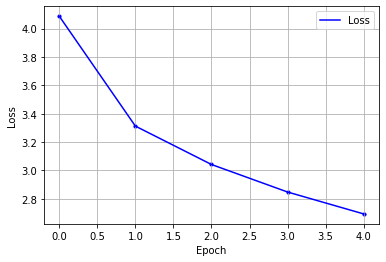

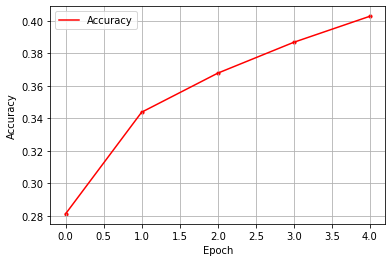

In [ ]:
import matplotlib.pyplot as plt
epoch = np.arange(5)
plt.plot(h.history['loss'], c = 'blue', label = 'Loss')
plt.scatter(epoch,h.history['loss'], c = 'blue', s =10)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend()
plt.show()

plt.plot(h.history['accuracy'], c = 'red', label = 'Accuracy')
plt.scatter(epoch,h.history['accuracy'], c = 'red', s =10)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend()
plt.show()

In [ ]:
images = '/content/drive/MyDrive/NLP_XLA_data/Flicker8k_Dataset'

In [ ]:
with open("/content/drive/MyDrive/NLP_XLA_data/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

In [ ]:
with open("/content/drive/MyDrive/NLP_XLA_data/encoded_train_images.pkl", "rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)

In [ ]:
in_text = 'startseq'
sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
sequence = pad_sequences([sequence], maxlen=max_length)
print(sequence)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 1]]


In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = m.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
f = greedySearch(encoding_test['3278777548_290b881018.jpg'].reshape((1,4096)))
f

'một người đàn_ông đang chơi trên một hồ'

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
import numpy as np
def score(x, y, num):
  """
  hàm tính điểm bleu cho mô hình
  """
  score = []
  step = 0
  for i in x:
    step +=1
    if(step ==num):
      break
    image = x[i].reshape((1,4096))
    tran = greedySearch(image)
    references = []
    candidate = []
    pre = y[i[:-4]]
    print('pre',pre)
    
    candidate.append(tran)
    references.append(pre)
    score1 = corpus_bleu(references, candidate, weights=(0.25, 0.25))
    score.append(score1)
    print(step)
  return np.mean(score)

In [ ]:
test = load_set(dir_Flickr_jpg_test)
test_descriptions = load_clean_descriptions('/content/drive/MyDrive/NLP_XLA_data/descriptions.txt', test)
print('BLEU score:',score(encoding_test, test_descriptions, 10))

468918320_9c275b877f.jpg


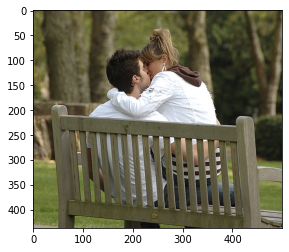

một cậu bé mặc áo xanh đang chơi trên một chướng_ngại_vật  / time: 2.543391704559326  seconds
190965502_0b9ed331d9.jpg


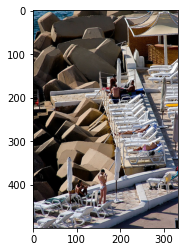

một người đàn_ông mặc đồ đen đang đứng trên một chiếc xe màu đỏ trên một bến_tàu  / time: 3.2834622859954834  seconds


In [ ]:
import time
for z in range(len(encoding_test)):
  start = time.time()
  pic = list(encoding_test.keys())[z+2]
  print(pic)
  image = encoding_test[pic].reshape((1,4096))
  x=plt.imread(images+"/"+pic)
  plt.imshow(x)
  plt.show()
  print(greedySearch(image), ' / time:', time.time() -start,' seconds')
  if (z ==1):
    break